Since, both Prophet and Holt Winters are performing much worse than the Naive Model, my next step is to use these models only for those counties which have large population. Here, any trends present in the small number of datapoints is more likely to be stable.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [2]:
orig = pd.read_csv('train.csv')

In [3]:
orig = orig.astype({'cfips':'category', 'county':'category', 
    'state':'category', 'first_day_of_month':'datetime64[ns]'})

In [4]:
orig.drop(columns = ['row_id', 'county'], inplace = True)

In [5]:
orig.sort_values(by=['cfips', 'first_day_of_month'])

,cfips,state,first_day_of_month,microbusiness_density,active
0,1001,Alabama,2019-08-01,3.007682,1249
1,1001,Alabama,2019-09-01,2.884870,1198
2,1001,Alabama,2019-10-01,3.055843,1269
3,1001,Alabama,2019-11-01,2.993233,1243
4,1001,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...
122260,56045,Wyoming,2022-06-01,1.803249,101
122261,56045,Wyoming,2022-07-01,1.803249,101
122262,56045,Wyoming,2022-08-01,1.785395,100
122263,56045,Wyoming,2022-09-01,1.785395,100


In [6]:
lastval = orig.groupby(by='cfips').last()

In [7]:
lastval.head()

,state,first_day_of_month,microbusiness_density,active
cfips,,,,
1001,Alabama,2022-10-01,3.463856,1472
1003,Alabama,2022-10-01,8.359798,14320
1005,Alabama,2022-10-01,1.232074,244
1007,Alabama,2022-10-01,1.287240,229
1009,Alabama,2022-10-01,1.831783,813


#### Calculate county population

In [8]:
# Calculate population of county from microbusiness_density and active microbusinesses
def pop(x):
    mbd = x['microbusiness_density']
    active = x['active']
    if active==0:
        return 0
    else:
        return int(active*100/mbd)
        
lastval['population'] = lastval.apply(lambda x: pop(x), axis = 1)

In [9]:
lastval.loc[lastval['population']==0]

,state,first_day_of_month,microbusiness_density,active,population
cfips,,,,,
28055,Mississippi,2022-10-01,0.0,0,0


In [10]:
lastval.loc[[28055], ['population']] = lastval[lastval['state']=='Mississippi']['population'].mean()

In [11]:
lastval.loc[[28055]]

,state,first_day_of_month,microbusiness_density,active,population
cfips,,,,,
28055,Mississippi,2022-10-01,0.0,0,27725.780488


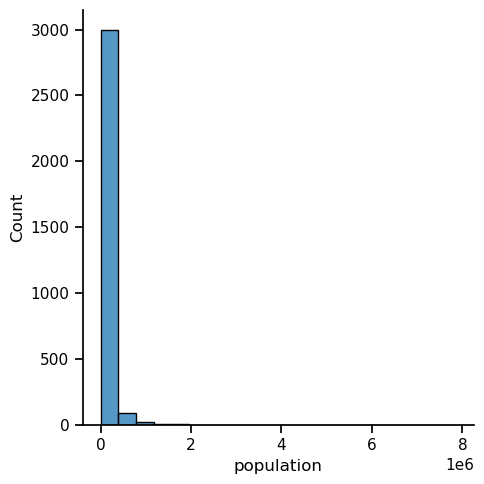

In [12]:
sns.displot(x = 'population', data = lastval, kind = 'hist', bins = 20)

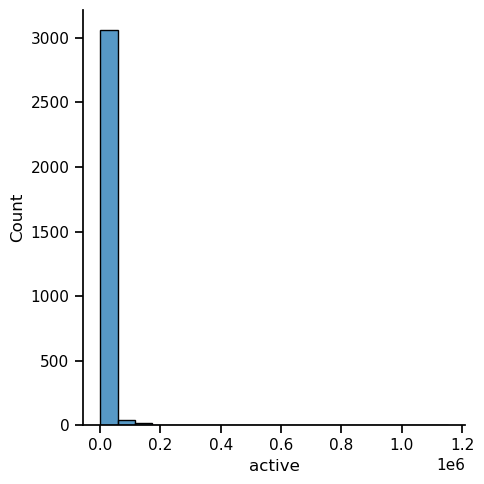

In [13]:
sns.displot(x='active', data=lastval, kind='hist', bins=20)


#### Make list of counties for which holt winters is to be used

In [37]:
# Population Threshold above which Holt Winter will be used
POP_THRESHOLD = 1000000
# Active Threshold above which Holt Winters will be used
ACT_THRESHOLD = 100000

holt_cfips = lastval.loc[(lastval['population'] > POP_THRESHOLD) & (
    lastval['active'] > ACT_THRESHOLD)].index
len(holt_cfips)

25

In [38]:
holt_cfips

CategoricalIndex([ 4013,  6001,  6037,  6059,  6065,  6073,  6085, 12011,
                  12057, 12086, 12095, 12099, 17031, 25017, 32003, 36047,
                  36059, 36061, 36081, 36103, 48029, 48113, 48201, 48439,
                  53033],
                 categories=[1001, 1003, 1005, 1007, ..., 56039, 56041, 56043, 56045], ordered=False, dtype='category', name='cfips')

#### Create Ensemble

In [39]:
# Weight of holt winters prediction to be used for averaging
HOLT_WEIGHT = 0.05

In [40]:
submission_holt = pd.read_csv('submission_holt_winters.csv')
submission_base = pd.read_csv('submission_base.csv')
test = pd.read_csv('test.csv')

In [41]:
ensemble = pd.DataFrame()
ensemble['row_id'] = test['row_id']
ensemble['microbusiness_density'] = 0

In [35]:
for i in test.index:
    if test.iloc[[i], [1]].values[0][0] in holt_cfips:
        ensemble.iloc[[i], [1]
                      ] = (1-HOLT_WEIGHT)*submission_base.iloc[[i], [1]].values[0][0] + HOLT_WEIGHT*submission_holt.iloc[[i], [1]].values[0][0]
    else:
        ensemble.iloc[[i], [1]
                      ] = submission_base.iloc[[i], [1]].values[0][0]


In [36]:
ensemble.to_csv('submission_holt_and_base_2.csv', index=False)

Kaggle SMAPE = 1.903, a little better than Naive (on the fourth decimal place according to kaggle). I should increase ACT_THRESHOLD, POP_THRESHOLD or decrease HOLT_WEIGHT